In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 3
setup_one_gpu(GPU)

Picking GPU 3


In [2]:
import numpy as np
import os.path as osp

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir

from tf_lab.in_out.basics import Data_Splitter
from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.convenience import reconstruct_pclouds
from tf_lab.data_sets.shape_net import snc_category_to_synth_id
from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats

In [14]:
def load_an_auto_encoder(b_neck, ae_experiment_tag, ae_loss, n_pc_points=2048):
    # Load Auto-Encoder
    ae_id = '_'.join(['ae', class_name, ae_experiment_tag, str(n_pc_points), 'pts', str(b_neck), 'bneck', ae_loss])
    ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
    ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))    
    val_error, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))        
    print best_epoch
    best_epoch = 500
    if best_epoch % ae_conf.saver_step != 0:
        best_epoch += best_epoch % ae_conf.saver_step
    ae_conf.encoder_args['verbose'] = False
    ae_conf.decoder_args['verbose'] = False
    reset_tf_graph()
    ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)
    ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)
    return ae

In [4]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [5]:
class_name = 'chair'
syn_id = snc_category_to_synth_id()[class_name]
n_pc_points = 2048
top_data_dir = '/orions4-zfs/projects/optas/DATA'
ae_experiment_tag = 'mlp_with_split_1pc_usampled_bnorm_on_encoder_only'

In [6]:
# in_data = load_multiple_version_of_pcs('uniform_one', syn_id, n_classes=1)
in_data = dict()
splits = ['train', 'test', 'val']
top_gt_dir = '/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/gt_data'
for s in splits:
    in_gt_file = osp.join(top_gt_dir, class_name + '_' + s + '.npz')
    gt_data = np.load(in_gt_file)  
    in_data[s] = gt_data[gt_data.keys()[0]]

In [7]:
ae_loss = 'chamfer'
b_neck = 128
top_out_dir = '/orions4-zfs/projects/optas/DATA/'
save_dir = osp.join(top_out_dir, 'OUT/iclr/evaluations/decoded_gt_data_aligned_to_gt/', \
                    class_name, ae_experiment_tag, ae_loss +'_bneck_'+ str(b_neck))
create_dir(save_dir)

'/orions4-zfs/projects/optas/DATA/OUT/iclr/evaluations/decoded_gt_data_aligned_to_gt/chair/mlp_with_split_1pc_usampled_bnorm_on_encoder_only/chamfer_bneck_128'

In [15]:
ae_model = load_an_auto_encoder(b_neck, ae_experiment_tag, ae_loss)

600
INFO:tensorflow:Restoring parameters from /orions4-zfs/projects/optas/DATA/OUT/iclr/nn_models/ae_chair_mlp_with_split_1pc_usampled_bnorm_on_encoder_only_2048_pts_128_bneck_chamfer/models.ckpt-500
Model restored in epoch 500.


In [16]:
for s in ['train', 'test', 'val']:
    recon, loss = reconstruct_pclouds(ae_model, in_data[s], batch_size=100)
    print s, loss
    np.savez(osp.join(save_dir, s),  recon)

train 0.000432390949593
test 0.000613666992855
val 0.000635464432561


In [17]:
from geo_tool import Point_Cloud

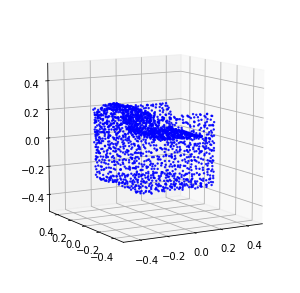

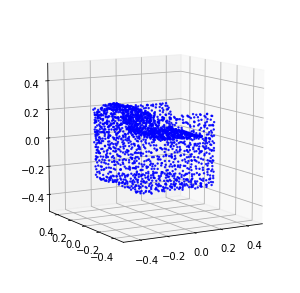

In [26]:
Point_Cloud(recon[4]).plot()